In [188]:
# Data processing tools: pandas and numpy
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [189]:
#matplotlib
def diag_radar(num_vars, frame = 'circle'):
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint = False)
    
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class AxesRadar(PolarAxes):

        name = 'radar'
        
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed = True, **kwargs):
            return super().fill(closed = closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknwn val 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes = self,
                              spine_type = 'circle',
                              path = Path.unit_regular_polygon(num_vars))
  
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(AxesRadar)
    return theta

def make_diagram(input, titles):
    data = [titles, ('Resulting Diagram', [])]
    for key in input.keys():
        data[1][1].append(input[key])
    N = len(data[0])
    theta = diag_radar(N, 'polygon')

    vertices_labels = data.pop(0)
    title, case_data = data[0]

    fig, ax = plt.subplots(figsize = (7, 7), subplot_kw = dict(projection = 'radar'))
    fig.subplots_adjust(top = 0.9, bottom = 0.1)

    ax.set_rgrids([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_title(title,  position = (0.5, 1.1), ha = 'center')

    for key, d in zip(input.keys(), case_data):
        line = ax.plot(theta, d, label = key)
        ax.fill(theta, d, alpha = 0.2)
        ax.set_varlabels(vertices_labels)
    
    plt.legend(loc ='lower right')
    plt.show()

In [190]:
input = {
    "Method 0": np.array([0.1, 0.2, 0.5, 0.3, 0.2, 0.1, 0.4, 0.5, 0.6]),
    "Method 1": np.array([0.2, 0.1, 0.1, 0.4, 0.1, 0.2, 0.5, 0.7, 0.2]),
    "Method 2": np.array([0.3, 0.4, 0.2, 0.6, 0.3, 0.3, 0.6, 0.8, 0.3]),
    "Method 3": np.array([0.4, 0.3, 0.4, 0.7, 0.5, 0.4, 0.3, 0.1, 0.4]),
    "Method 4": np.array([0.35, 0.35, 0.45, 0.75, 0.55, 0.45, 0.35, 0.05, 0.35])
}

titles = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

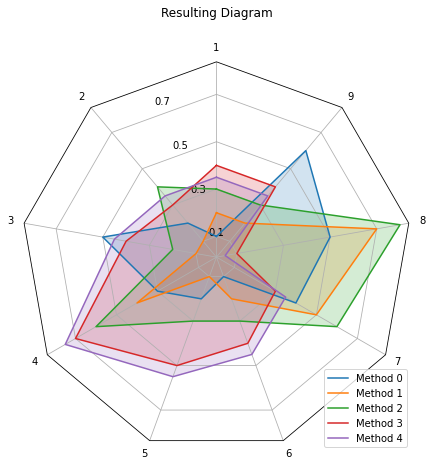

In [191]:
make_diagram(input, titles)